# Analyzing and modeling datasets

## Importing and performing rudimentary analysis

In [42]:
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import statsmodels.regression.linear_model as slm

In [2]:
the_rng = np.random.default_rng(seed=7)

## Basic modeling and inference of data

### Terminology

- **Feature:** column name, independent variable, some type of data that can be related to the output variable
- **Target:** the dependent variable or output of the model
- **Instance:** a "row" or observation of data that includes the independent variables and the dependent variable
- **Training data:** instances used for building the regression/classification model
- **Testing data:** instances used for testing the validity of the regression/classification model
- **Residual:** the difference between the estimated output values from the model and the true output values from the data
- **Inference:** Inferring the properties of an underlying distribution (making conclusions from data subject to random variation).
- **Parameter:** a summary statistic of the population we are interested in

### Distributions

This class will be all about distributions.  Why?

Because all physical data and models are about distributions.

In this module of EE 5020, we focus on **frequentist** (classical) statistics, where we assume the Gaussian and whether features can be parameterized as such.

You'll see Bayesian statistics in the next module, where data is treated as informing a probability estimate instead.

#### Distribution terminology
- **pdf:** probability density function, probability for each possible value of a **continuous** random variable
- **pmf:** probability mass function, probability for each possible value of a **discrete** random variable
- **cdf:** cumulative distribution function, cumulative probability for each value (and the ones before it)
- **samples:** just like with signals, samples (instant values) are drawn from a random variable (which conforms to some distribution)

#### Trying out distributions

Let's try to draw some samples and plot a few distributions using NumPy:

[6 9 3 9 0 6 4 5 6 2]


<AxesSubplot:ylabel='Count'>

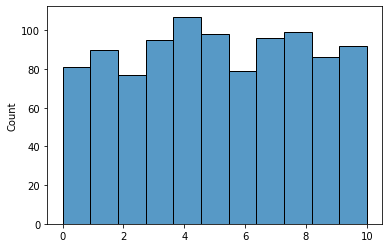

In [5]:
random_integer_sample = the_rng.integers(low=0, high=10, endpoint=True, size=1000)
print(random_integer_sample[0:10])
sns.histplot(data=random_integer_sample)

<AxesSubplot:ylabel='Count'>

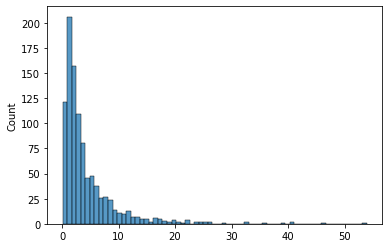

In [6]:
lognormal_sample = the_rng.lognormal(mean=1.0, sigma=1.0, size=1000)
sns.histplot(data=lognormal_sample)

Now let's try to draw some samples and plot a few distributions using SciPy:

<AxesSubplot:ylabel='Count'>

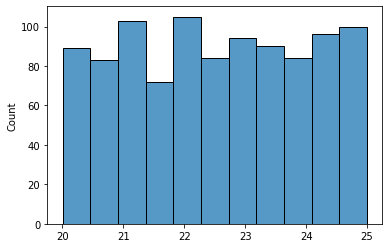

In [7]:
uniform_sample = sp.stats.uniform.rvs(loc=20., scale=5., size=1000, random_state=the_rng)
sns.histplot(data=uniform_sample)

<AxesSubplot:ylabel='Count'>

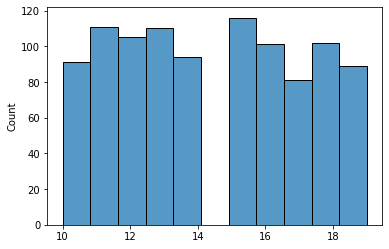

In [9]:
randint_sample = sp.stats.randint.rvs(low=10, high=20, size=1000, random_state=the_rng)
sns.histplot(data=randint_sample)

The special thing about SciPy distributions are that you can generate a "frozen" random variable, meaning that you can set the low, high, random state, etc. of a distribution, and just keep drawing from that same distribution.

To do this, rather than calling the `.rvs()` function of the distribution name, create the distribution as an object, then call `.rvs()` on your named distribution object instead, as I'll show.

Let's pretend that the optimal performance of an integrated circuit relative to its clock speed can be modeled as a Rayleigh distribution with a peak at 120 MHz and a scale of 20 MHz:

In [19]:
dist_ic_perf_clockspeed_peak = 120.
dist_ic_perf_clockspeed_spread = 20.

dist_ic_perf_clockspeed = sp.stats.rayleigh(loc=dist_ic_perf_clockspeed_peak - dist_ic_perf_clockspeed_spread,
                                            scale=dist_ic_perf_clockspeed_spread)

Text(0.5, 0, 'Clock speed (MHz)')

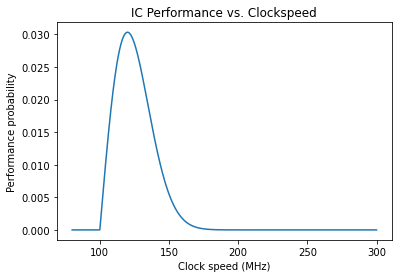

In [23]:
# examine the pdf directly rather than drawing samples:
dist_ic_perf_clockspeed_pdf_x = np.linspace(start=80., stop=300., num=1000)
dist_ic_perf_clockspeed_pdf_y = dist_ic_perf_clockspeed.pdf(dist_ic_perf_clockspeed_pdf_x)

dist_ic_perf_clockspeed_pdf_plot = sns.lineplot(
    x=dist_ic_perf_clockspeed_pdf_x, y=dist_ic_perf_clockspeed_pdf_y)

dist_ic_perf_clockspeed_pdf_plot.set_title("IC Performance vs. Clockspeed")
dist_ic_perf_clockspeed_pdf_plot.set_ylabel("Performance probability")
dist_ic_perf_clockspeed_pdf_plot.set_xlabel("Clock speed (MHz)")

The neatest thing is that you can attempt to fit data with a continuous distribution and examine the potential fits!

For more info, see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit

We'll see if we can fit our perfectly uniform data (literally just repeated increments of numbers) to a uniform continuous distribution!

In [34]:
data_perfect = np.repeat(np.arange(0, 10.5, 0.1), 10)  # include the endpoint 10.4
print(data_perfect)

[ 0.   0.   0.  ... 10.4 10.4 10.4]


In [35]:
sp.stats.uniform.fit(data=data_perfect)  # returns parameters for the uniform distribution

(0.0, 10.4)

### Linear regression

Let's try using the `statsmodels` for linear regression!  There's a few different methods we'll go over, [see the statsmodels documentation on linear regression](https://www.statsmodels.org/stable/regression.html).

Why do we think about distributions when we are performing linear regression?  Because all of our analysis assumes the following:

![linear regression](./linear_regression.png)

Sometimes, a feature can be transformed using the `np.log10()` or `np.log()` function to attempt to normalize it.

#### Building models using toy data

Let's visualize this by making up some toy problems before we build models of real datasets.

We'll make a simple regression problem based on sampling from the equation `y = 2x + 5`.  We'll set up the vectors, then add some noise and attempt linear regression plots.

In [36]:
toy_sample_size = 21
toy_sample_bound_left = -10.0
toy_sample_bound_right = 10.0

toy_x = np.linspace(start=toy_sample_bound_left,
                    stop=toy_sample_bound_right,
                    num=toy_sample_size)

In [38]:
toy_y = 2. * toy_x + 5.
print(toy_y)

[-15. -13. -11.  -9.  -7.  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.
  13.  15.  17.  19.  21.  23.  25.]


<AxesSubplot:>

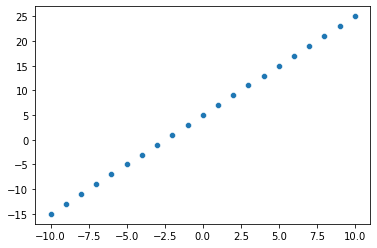

In [39]:
sns.scatterplot(x=toy_x, y=toy_y)

For info about OLS (ordinary least squares), see: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

Verify that we get the same model back when using `statsmodels` for regression since we have no noise:

In [46]:
import statsmodels.api as sa

# add the intercept, which is just a vector of 1s
toy_x_train = sa.add_constant(toy_x)

model_perfect = slm.OLS(endog=toy_y, exog=toy_x_train)
model_perfect_results = model_perfect.fit()
model_perfect_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.159e+33
Date:                Fri, 09 Sep 2022   Prob (F-statistic):          1.98e-303
Time:                        14:05:07   Log-Likelihood:                 686.31
No. Observations:                  21   AIC:                            -1369.
Df Residuals:                      19   BIC:                            -1367.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0000   3.56e-16   1.41e+16      0.000       5.000       5.000
x1             2.0000   5.87e-17    3.4e+16      0.000       2.000       2.000
==============================================================================
Omnibus:                        6.221   Durbin-Watson:                   0.062
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.502
Skew:                          -1.230   Prob(JB):                       0.0639
Kurtosis:                       2.512   Cond. No.                         6.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

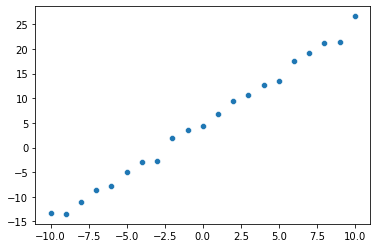

In [41]:
dist_noise = sp.stats.norm(loc=0., scale=1.0)

# reset the random number generator to a known state so our experiment is consistent
noise_samples = dist_noise.rvs(size=len(toy_x), random_state=7)

noisy_y = toy_y + noise_samples

sns.scatterplot(x=toy_x, y=noisy_y)

You'll see that `statsmodels` can return a lot of different statistics about the regression model.

#### Building models using real data

Datasets:
1. https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
2. https://data.lacity.org/City-Infrastructure-Service-Requests/LADWP-Power-Outages/tdb2-bvuq
3. http://www.laalmanac.com/weather/we04a.php
4. https://www.californiadgstats.ca.gov/downloads/
